In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# =====================================================
# 데이터 로드 + 시간 파생
# =====================================================
df = pd.read_csv("new_flight_weather_merged.csv")

df["departure_datetime"] = pd.to_datetime(df["departure_datetime"])
df["dep_hour"] = df["departure_datetime"].dt.hour
df["dep_weekday"] = df["departure_datetime"].dt.weekday
df["is_weekend"] = df["dep_weekday"].isin([5, 6]).astype(int)

# =====================================================
# 컬럼 정의
# =====================================================
num_cols = ["기온(°C)", "풍속_ms", "dep_hour", "dep_weekday", "is_weekend"]
num_cols = [c for c in num_cols if c in df.columns]

cat_cols = ["공항명", "출발지", "도착지", "flight_type"]
cat_cols = [c for c in cat_cols if c in df.columns]

# 👉 LightGBM용 category 변환
for c in cat_cols:
    df[c] = df[c].astype("category")

X_cols = num_cols + cat_cols

# =====================================================
# Train / Test 분리
# =====================================================
df = df.sort_values("departure_datetime")
split_date = df["departure_datetime"].quantile(0.8)

train_df = df[df["departure_datetime"] <= split_date]
test_df  = df[df["departure_datetime"] > split_date]

X_train = train_df[X_cols]
y_train = train_df["is_delay"]

X_test  = test_df[X_cols]
y_test  = test_df["is_delay"]

# =====================================================
# LightGBM 모델
# =====================================================
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,

    class_weight="balanced",
    objective="binary",
    metric="aucpr",
    random_state=42,
    n_jobs=-1
)

# ✅ categorical_feature 지정
lgbm.fit(
    X_train,
    y_train,
    categorical_feature=cat_cols
)

print("✅ LightGBM 학습 완료")

# =====================================================
# 평가
# =====================================================
y_prob = lgbm.predict_proba(X_test)[:, 1]

for t in [0.3, 0.35, 0.4, 0.45]:
    print(f"\n===== Threshold = {t} =====")
    y_pred = (y_prob >= t).astype(int)
    print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC :", average_precision_score(y_test, y_prob))


C:\Users\Admin\AppData\Local\Temp\ipykernel_4296\3419503244.py:9: DtypeWarning: Columns (29,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("new_flight_weather_merged.csv")


[LightGBM] [Info] Number of positive: 336343, number of negative: 1938804
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 2275147, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ LightGBM 학습 완료

===== Threshold = 0.3 =====
              precision    recall  f1-score   support

           0       0.90      0.33      0.49    422243
           1       0.32      0.90      0.47    146544

    accuracy                           0.48    568787
   macro avg       0.61      0.62      0.48    568787
weighted avg       0.75      0.48      0.48    568787


===== Threshold = 0.35 =====
              precision    recall  f

## 📊 시각화: 성능 요약 표 & 그래프

아래 셀들은 **기존 코드(학습/예측/평가)** 실행이 끝난 뒤, 맨 아래에서 추가로 실행하면 됩니다.  
(기존 코드는 그대로 유지했고, 시각화만 "추가"했습니다.)


In [2]:
# =====================================================
# 📌 시각화 준비: 변수 자동 탐색 + 기본 성능 요약 표 생성
# -----------------------------------------------------
# ✅ 이 셀은 "기존 코드"에서 만든 변수들을 최대한 자동으로 찾아서,
#    - y_true (정답)
#    - y_proba (예측 확률)
#    - y_pred (예측 라벨)
#    - model (학습 모델)
#    - X_test (테스트 독립변수)
# 를 확보한 뒤, 표로 정리합니다.
#
# ⚠️ 노트북마다 변수명이 조금씩 다를 수 있어서,
#    아래 코드가 여러 후보 이름을 순서대로 탐색합니다.
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

def _pick_first_existing(name_candidates):
    # 여러 변수명 후보 중에서 현재 노트북 실행 환경(globals)에 존재하는
    # '첫 번째' 변수를 찾아 (값, 변수명) 형태로 반환
    for n in name_candidates:
        if n in globals():
            return globals()[n], n
    return None, None

def _as_1d_array(x):
    # 리스트/시리즈/넘파이 등 -> 1차원 np.array로 안전하게 변환
    if x is None:
        return None
    try:
        arr = np.array(x)
        # (N,1) 또는 (1,N) 같은 형태면 1차원으로 펼침
        return arr.reshape(-1)
    except Exception:
        return None

# -----------------------------------------------------
# 1) y_true(정답) 자동 탐색
# -----------------------------------------------------
y_true, y_true_name = _pick_first_existing([
    "y_test", "test_y", "y_valid", "y_val", "y_true", "Y_test", "Y_val"
])
y_true = _as_1d_array(y_true)

# -----------------------------------------------------
# 2) X_test(테스트 독립변수) 자동 탐색 (피처명 추출용)
# -----------------------------------------------------
X_test, X_test_name = _pick_first_existing([
    "X_test", "test_X", "X_valid", "X_val", "X_te", "x_test"
])

# -----------------------------------------------------
# 3) model(학습 모델) 자동 탐색
# -----------------------------------------------------
# ✅ 비교 노트북(여러 모델)도 있을 수 있어서, 흔한 이름들을 넓게 탐색합니다.
model, model_name = _pick_first_existing([
    "model", "clf", "classifier",
    "lgb_model", "lgbm_model", "lgbm",
    "xgb_model", "xgb", "xgb_clf",
    "best_model", "final_model"
])

# -----------------------------------------------------
# 4) y_proba(예측 확률) 자동 탐색
# -----------------------------------------------------
# ✅ 이미 만들어둔 확률 변수가 있으면 그걸 우선 사용합니다.
y_proba, y_proba_name = _pick_first_existing([
    "y_proba", "y_pred_proba", "pred_proba", "proba",
    "y_score", "scores", "prob", "p_pred"
])

# ✅ 확률 변수가 없으면, model + X_test로 직접 계산을 시도합니다.
if y_proba is None and model is not None and X_test is not None:
    try:
        # sklearn / xgboost / lightgbm 대부분은 predict_proba 지원
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test)
            # 보통 이진분류는 (N, 2) -> positive class 확률은 [:, 1]
            if isinstance(proba, np.ndarray) and proba.ndim == 2 and proba.shape[1] >= 2:
                y_proba = proba[:, 1]
                y_proba_name = f"{model_name}.predict_proba({X_test_name})[:,1]"
            else:
                # 혹시 (N,)으로 바로 나오는 경우
                y_proba = proba
                y_proba_name = f"{model_name}.predict_proba({X_test_name})"
        # decision_function만 있는 모델도 존재할 수 있음 (SVM 등)
        elif hasattr(model, "decision_function"):
            score = model.decision_function(X_test)
            y_proba = score
            y_proba_name = f"{model_name}.decision_function({X_test_name})"
    except Exception as e:
        print("⚠️ model로부터 예측 확률(y_proba) 계산 실패:", repr(e))

y_proba = _as_1d_array(y_proba)

# -----------------------------------------------------
# 5) y_pred(예측 라벨) 자동 탐색
# -----------------------------------------------------
y_pred, y_pred_name = _pick_first_existing([
    "y_pred", "pred", "y_hat", "y_pred_label"
])

# ✅ y_pred가 없으면, y_proba로 threshold=0.5 기준 라벨 생성
if y_pred is None and y_proba is not None:
    y_pred = (y_proba >= 0.5).astype(int)
    y_pred_name = "derived_from_y_proba(threshold=0.5)"

y_pred = _as_1d_array(y_pred)

# -----------------------------------------------------
# 6) 확보한 변수들 요약 출력
# -----------------------------------------------------
print("✅ [자동 탐색 결과]")
print(f" - y_true  : {y_true_name}")
print(f" - y_proba : {y_proba_name}")
print(f" - y_pred  : {y_pred_name}")
print(f" - model   : {model_name}")
print(f" - X_test  : {X_test_name}")

# -----------------------------------------------------
# 7) 기본 성능 요약 표(이진분류 기준)
# -----------------------------------------------------
# ⚠️ y_true 또는 y_pred가 없으면 표를 만들 수 없으니 안내 후 종료합니다.
if y_true is None or y_pred is None:
    raise ValueError("y_true 또는 y_pred를 찾지 못했습니다. (기존 코드에서 test 정답/예측 변수를 만든 뒤 다시 실행하세요.)")

# ✅ classification_report를 DataFrame으로 변환 (표로 보기 좋게)
report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T

# ✅ 전체 스칼라 지표(있을 때만 계산)
metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "precision(binary)": precision_score(y_true, y_pred, zero_division=0),
    "recall(binary)": recall_score(y_true, y_pred, zero_division=0),
    "f1(binary)": f1_score(y_true, y_pred, zero_division=0),
}

# ✅ 확률이 있으면 ROC-AUC / PR-AUC도 계산
if y_proba is not None:
    try:
        metrics["roc_auc"] = roc_auc_score(y_true, y_proba)
    except Exception:
        metrics["roc_auc"] = np.nan
    try:
        metrics["pr_auc(AP)"] = average_precision_score(y_true, y_proba)
    except Exception:
        metrics["pr_auc(AP)"] = np.nan
else:
    metrics["roc_auc"] = np.nan
    metrics["pr_auc(AP)"] = np.nan

metrics_df = pd.DataFrame([metrics])

print("\n✅ [성능 요약(스칼라)]")
display(metrics_df)

print("\n✅ [Classification Report (표)]")
display(report_df)

# -----------------------------------------------------
# 8) Confusion Matrix(혼동행렬) 표
# -----------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

print("\n✅ [Confusion Matrix (표)]")
display(cm_df)

# -----------------------------------------------------
# 9) Threshold(임계값) 스윕 테이블
# -----------------------------------------------------
# ✅ 확률(y_proba)이 있을 때만 의미가 있으므로, 없으면 스킵합니다.
if y_proba is not None:
    thresholds = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thresholds:
        yp = (y_proba >= t).astype(int)
        rows.append({
            "threshold": float(np.round(t, 2)),
            "accuracy": accuracy_score(y_true, yp),
            "precision": precision_score(y_true, yp, zero_division=0),
            "recall": recall_score(y_true, yp, zero_division=0),
            "f1": f1_score(y_true, yp, zero_division=0),
        })
    thr_df = pd.DataFrame(rows).sort_values("threshold")
    print("\n✅ [Threshold 스윕 성능 표] (확률 기반)")
    display(thr_df)
else:
    thr_df = None
    print("\nℹ️ y_proba(예측 확률)가 없어 threshold 스윕 표는 생략합니다.")


✅ [자동 탐색 결과]
 - y_true  : y_test
 - y_proba : lgbm.predict_proba(X_test)[:,1]
 - y_pred  : y_pred
 - model   : lgbm
 - X_test  : X_test

✅ [성능 요약(스칼라)]


,accuracy,precision(binary),recall(binary),f1(binary),roc_auc,pr_auc(AP)
0,0.602545,0.36463,0.730845,0.486525,0.706201,0.457276



✅ [Classification Report (표)]


,precision,recall,f1-score,support
0,0.856603,0.558018,0.675799,422243.000000
1,0.364630,0.730845,0.486525,146544.000000
accuracy,0.602545,0.602545,0.602545,0.602545
macro avg,0.610617,0.644431,0.581162,568787.000000
weighted avg,0.729850,0.602545,0.627034,568787.000000



✅ [Confusion Matrix (표)]


,Pred 0,Pred 1
Actual 0,235619,186624
Actual 1,39443,107101



✅ [Threshold 스윕 성능 표] (확률 기반)


,threshold,accuracy,precision,recall,f1
0,0.05,0.271042,0.260995,0.998819,0.413849
1,0.10,0.306327,0.269699,0.990945,0.424000
2,0.15,0.350706,0.281327,0.977836,0.436943
3,0.20,0.390830,0.292232,0.959534,0.448018
4,0.25,0.431682,0.303757,0.933235,0.458332
5,0.30,0.478991,0.318683,0.898317,0.470465
6,0.35,0.523305,0.334052,0.855736,0.480523
7,0.40,0.564148,0.349312,0.801705,0.486604
8,0.45,0.602545,0.364630,0.730845,0.486525
9,0.50,0.640581,0.383221,0.648160,0.481662


In [3]:
# ===============================
# ✅ 한글 폰트 깨짐 방지 설정
# ===============================
import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm

system = platform.system()

if system == "Windows":
    # Windows (대부분 Malgun Gothic 사용)
    plt.rcParams["font.family"] = "Malgun Gothic"

elif system == "Darwin":
    # macOS
    plt.rcParams["font.family"] = "AppleGothic"

else:
    # Linux (Colab / 서버)
    # 나눔고딕이 없을 경우 대비
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        plt.rcParams["font.family"] = "DejaVu Sans"

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

print(f"✅ 한글 폰트 설정 완료 ({system})")


✅ 한글 폰트 설정 완료 (Windows)


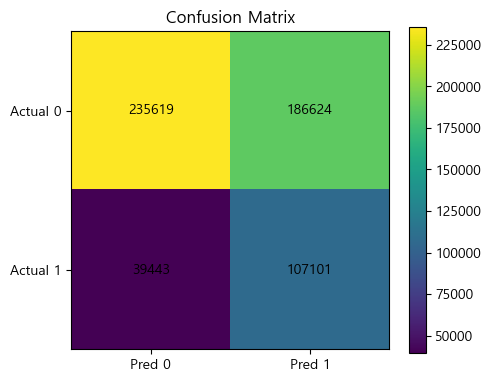

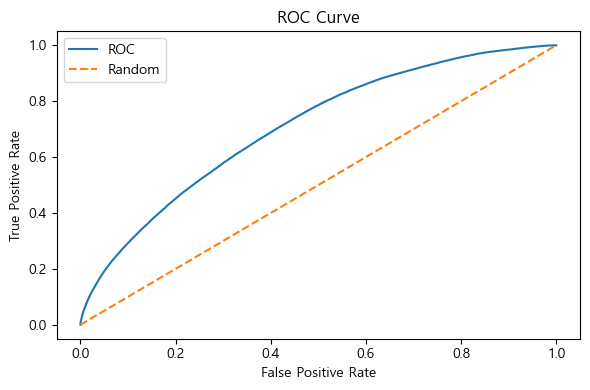

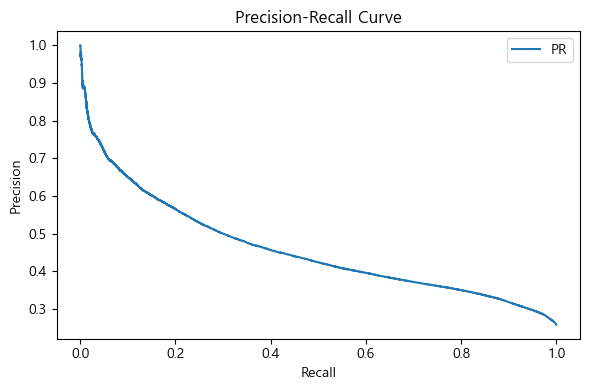

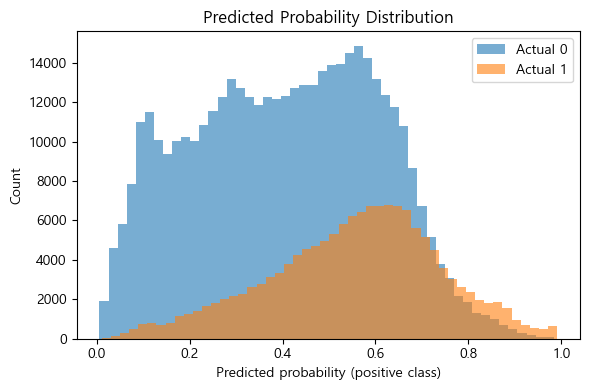

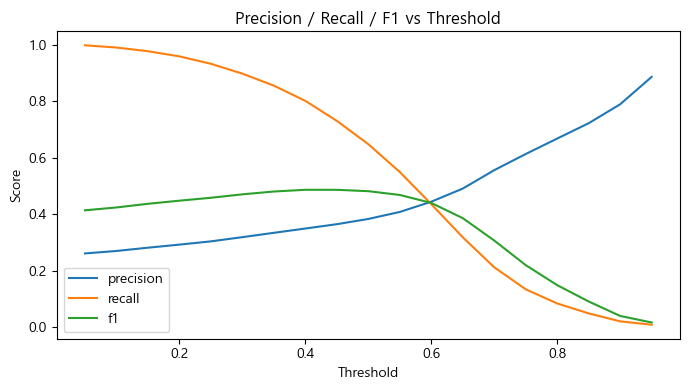

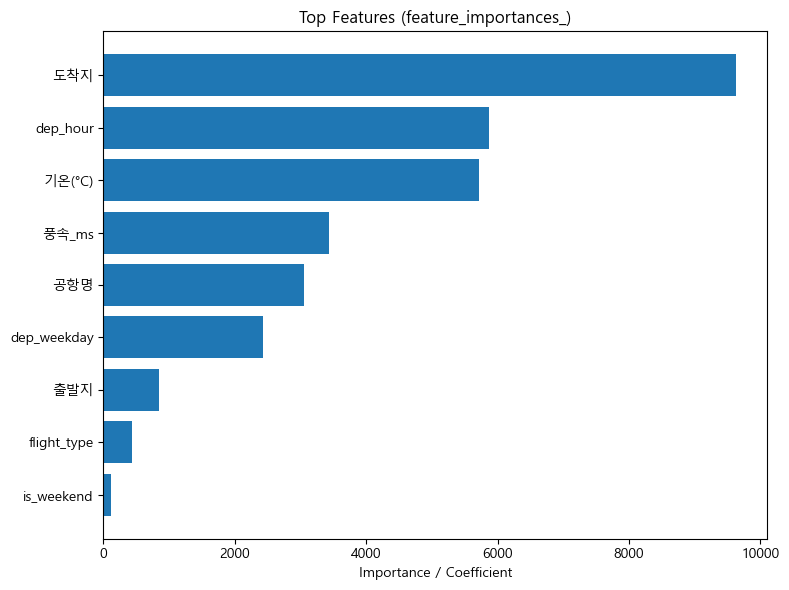

In [4]:
# =====================================================
# 📈 시각화: 혼동행렬 / ROC / PR / 확률분포 / 임계값 곡선 / 중요 피처
# -----------------------------------------------------
# ✅ 이 셀은 위 셀에서 만든(또는 찾은) 변수(y_true, y_pred, y_proba, model, X_test)를 사용합니다.
# ✅ 그래프는 matplotlib 기본 스타일(색 지정 없음)로 그립니다.
# =====================================================

from sklearn.metrics import roc_curve, precision_recall_curve

# -----------------------------------------------------
# 1) 혼동행렬(Confusion Matrix) 시각화
# -----------------------------------------------------
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Pred 0", "Pred 1"])
plt.yticks(tick_marks, ["Actual 0", "Actual 1"])

# ✅ 셀 안에 숫자(건수) 표시
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# 2) ROC Curve (확률이 있을 때만)
# -----------------------------------------------------
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label="ROC")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 3) Precision-Recall Curve (확률이 있을 때만)
# -----------------------------------------------------
if y_proba is not None:
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label="PR")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 4) 예측 확률 분포(클래스별) (확률이 있을 때만)
# -----------------------------------------------------
# ✅ 클래스 0과 1의 예측 확률 분포를 따로 그리면,
#    모델이 어느 정도로 두 클래스를 "분리"하는지 직관적으로 확인 가능합니다.
if y_proba is not None:
    y_proba_0 = y_proba[y_true == 0]
    y_proba_1 = y_proba[y_true == 1]

    plt.figure(figsize=(6, 4))
    plt.hist(y_proba_0, bins=50, alpha=0.6, label="Actual 0")
    plt.hist(y_proba_1, bins=50, alpha=0.6, label="Actual 1")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted probability (positive class)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 5) Threshold(임계값) 변화에 따른 Precision/Recall/F1 곡선 (확률이 있을 때만)
# -----------------------------------------------------
if thr_df is not None:
    plt.figure(figsize=(7, 4))
    plt.plot(thr_df["threshold"], thr_df["precision"], label="precision")
    plt.plot(thr_df["threshold"], thr_df["recall"], label="recall")
    plt.plot(thr_df["threshold"], thr_df["f1"], label="f1")
    plt.title("Precision / Recall / F1 vs Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------
# 6) 중요 피처(Feature Importance / Coef) Top 20
# -----------------------------------------------------
# ✅ 트리 기반 모델(lightgbm/xgboost 등): feature_importances_
# ✅ 선형 모델(logistic regression 등): coef_
#
# ⚠️ 피처명이 필요합니다. 보통 X_test가 DataFrame이면 columns로 가져옵니다.
#    (numpy array이면, 피처명을 모를 수 있어 index로 표시합니다.)
# -----------------------------------------------------
feature_names = None
if X_test is not None:
    try:
        if hasattr(X_test, "columns"):
            feature_names = list(X_test.columns)
        else:
            # numpy array인 경우: 피처명 없음 -> 번호로 대체
            feature_names = [f"f{i}" for i in range(X_test.shape[1])]
    except Exception:
        feature_names = None

def _plot_top_features(values, names, title, top_n=20):
    # 중요도/계수 배열(values)와 피처명(names)으로 Top-N 막대그래프를 그립니다.
    # - values: (num_features,) 형태
    # - names : 길이 num_features
    s = pd.Series(values, index=names)
    # 절대값 기준 Top-N (양/음 모두 중요할 수 있어서)
    top = s.reindex(s.abs().sort_values(ascending=False).index).head(top_n)
    top = top.iloc[::-1]  # 보기 좋게 역순
    plt.figure(figsize=(8, 6))
    plt.barh(top.index, top.values)
    plt.title(title)
    plt.xlabel("Importance / Coefficient")
    plt.tight_layout()
    plt.show()

# ✅ model이 존재하고, feature_names가 있을 때만 시각화 시도
if model is not None and feature_names is not None:
    try:
        # 6-A) 트리 기반 importance
        if hasattr(model, "feature_importances_"):
            imp = np.array(model.feature_importances_).reshape(-1)
            if len(imp) == len(feature_names):
                _plot_top_features(imp, feature_names, "Top Features (feature_importances_)")
            else:
                print("⚠️ feature_importances_ 길이와 feature_names 길이가 달라 importance 시각화를 생략합니다.")
        # 6-B) 선형 모델 coef
        elif hasattr(model, "coef_"):
            coef = np.array(model.coef_).reshape(-1)
            if len(coef) == len(feature_names):
                _plot_top_features(coef, feature_names, "Top Features (coef_)")
            else:
                print("⚠️ coef_ 길이와 feature_names 길이가 달라 coef 시각화를 생략합니다.")
        else:
            print("ℹ️ 이 모델은 feature_importances_ 또는 coef_가 없어 중요 피처 시각화를 생략합니다.")
    except Exception as e:
        print("⚠️ 중요 피처 시각화 중 오류:", repr(e))
else:
    print("ℹ️ model 또는 feature_names를 확보하지 못해 중요 피처 시각화를 생략합니다.")

# -----------------------------------------------------
# 7) (옵션) 여러 모델 비교가 가능한 경우: models(dict)가 있으면 성능표 생성
# -----------------------------------------------------
# ✅ 비교 노트북에서 models = {"lgb":..., "xgb":..., ...} 형태로 가지고 있는 경우가 있어서
#    있으면 자동으로 돌려서 표를 만들어 줍니다.
# -----------------------------------------------------
models_dict = globals().get("models", None)

if isinstance(models_dict, dict) and X_test is not None and y_true is not None:
    rows = []
    for k, m in models_dict.items():
        try:
            # 예측 확률 계산
            if hasattr(m, "predict_proba"):
                p = m.predict_proba(X_test)
                if isinstance(p, np.ndarray) and p.ndim == 2 and p.shape[1] >= 2:
                    p = p[:, 1]
            elif hasattr(m, "decision_function"):
                p = m.decision_function(X_test)
            else:
                p = None

            # 예측 라벨(기본 threshold=0.5)
            if p is not None:
                yp = (np.array(p).reshape(-1) >= 0.5).astype(int)
                roc = roc_auc_score(y_true, p)
                pr = average_precision_score(y_true, p)
            else:
                yp = m.predict(X_test)
                roc = np.nan
                pr = np.nan

            rows.append({
                "model_name": k,
                "accuracy": accuracy_score(y_true, yp),
                "precision": precision_score(y_true, yp, zero_division=0),
                "recall": recall_score(y_true, yp, zero_division=0),
                "f1": f1_score(y_true, yp, zero_division=0),
                "roc_auc": roc,
                "pr_auc(AP)": pr
            })
        except Exception as e:
            rows.append({"model_name": k, "error": repr(e)})

    compare_df = pd.DataFrame(rows)
    print("\n✅ [여러 모델 비교 성능표]")
    display(compare_df)
